In [18]:
from rl_class import BlackjackEnv, QLearningAgent

env = BlackjackEnv()
agent = QLearningAgent(epsilon=0.1, lr=0.01)  # 0: Stand, 1: Hit

In [19]:
num_episodes = 500000

for i in range(num_episodes):
    state = env.reset()
    done = False
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state

    if i % 100000 == 0:
        print(f"Episode {i}/{num_episodes} completed.") 

Episode 0/500000 completed.
Episode 100000/500000 completed.
Episode 200000/500000 completed.
Episode 300000/500000 completed.
Episode 400000/500000 completed.


In [20]:
wins, losses, draws = 0, 0, 0
agent.epsilon = 0 # Désactive l'exploration

for _ in range(10000):
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        state, reward, done = env.step(action)
    
    if reward == 1: wins += 1
    elif reward == -1: losses += 1
    else: draws += 1

print(f"Results : {wins} Wins | {losses} Losses | {draws} Draws")
print(f"Win rate : {wins/10000:.2%}")

Results : 3791 Wins | 5343 Losses | 866 Draws
Win rate : 37.91%


We can observe that our agent wins only 36% of its games in a sample of 10,000. This score is surely due to an aggressive strategy.\
We can analyze our agent's strategy to try to deduce the reason for this low win rate and explore possibilities for improving our agent.

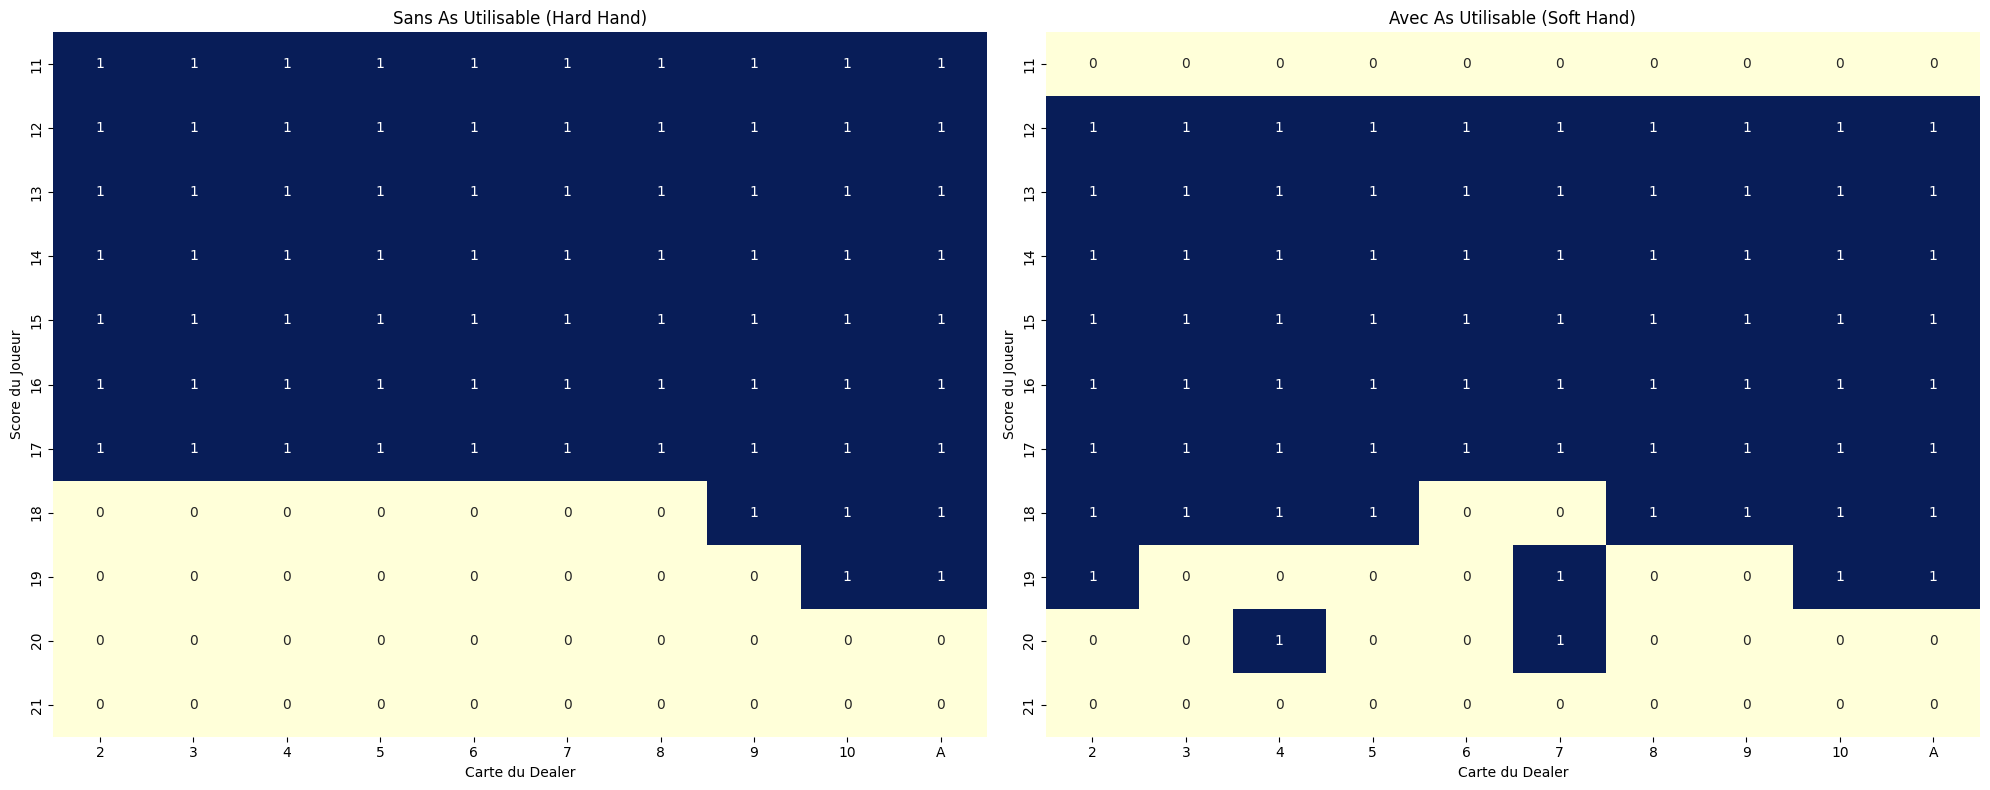

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison(agent):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    player_range = np.arange(11, 22)
    dealer_range = np.arange(2, 12)
    xticklabels = ['2','3','4','5','6','7','8','9','10','A']

    # --- First plot (Without Usable Ace) ---
    grid_no_ace = np.array([[np.argmax(agent.q_table.get((p, d, False), [0, 0])) 
                    for d in dealer_range] for p in player_range])
    
    sns.heatmap(grid_no_ace, annot=True, fmt="d", ax=ax1, cmap="YlGnBu", cbar=False,
                xticklabels=xticklabels, yticklabels=player_range)
    ax1.set_title("Without Usable Ace (Hard Hand)")
    ax1.set_xlabel("Dealer's Card")
    ax1.set_ylabel("Player's Score")

    # --- Second plot (With Usable Ace) ---
    grid_ace = np.array([[np.argmax(agent.q_table.get((p, d, True), [0, 0])) 
                        for d in dealer_range] for p in player_range])
    
    sns.heatmap(grid_ace, annot=True, fmt="d", ax=ax2, cmap="YlGnBu", cbar=False,
                xticklabels=xticklabels, yticklabels=player_range)
    ax2.set_title("With Usable Ace (Soft Hand)")
    ax2.set_xlabel("Dealer's Card")
    ax2.set_ylabel("Player's Score")

    plt.tight_layout()
    plt.savefig("comparison_strategies.png")
    plt.show()

# Usage
plot_comparison(agent)

From these results, we can observe that the agent has grasped the basic blackjack strategy, particularly the management of *"Hard Hands"* (playing more or less aggressively depending on the dealer's upcard).

The strategy for hands containing an Ace involves significantly more variance due to the relatively small number of Ace-containing hands. (It explains some exagerated decisions, e.g. the Hit action on (20, 7, 1) state)

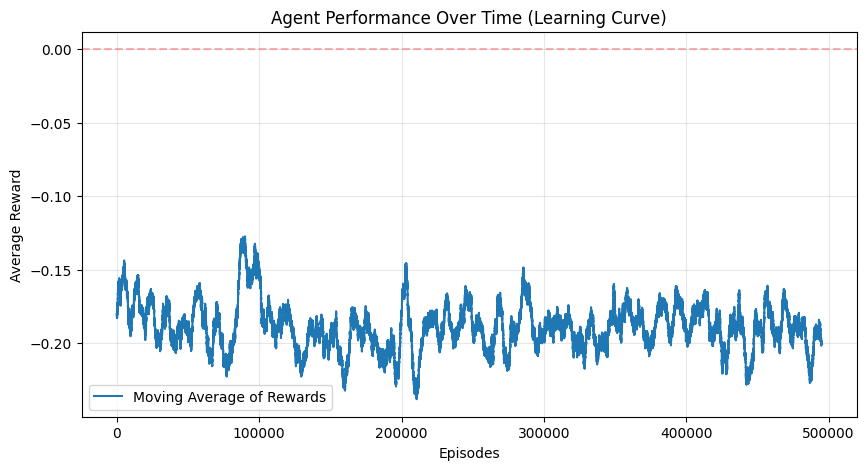

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# List to store rewards per episode
rewards = []
num_episodes = 500000

for i in range(num_episodes):
    state = env.reset()
    done = False
    ep_reward = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        ep_reward = reward # Final reward of the round
        
    rewards.append(ep_reward)

# Calculate moving average (smoothing over 5000 episodes)
window = 5000
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(moving_avg, label="Moving Average of Rewards")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3) # Equilibrium line
plt.title("Agent Performance Over Time (Learning Curve)")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("learning_curve.png")
plt.show()

Here we observe that the results are very unstable, but the average reward hovers around -0.18.

We know that the average reward for a highly optimized human strategy is around -0.05. This is a decent score for an approach like this.

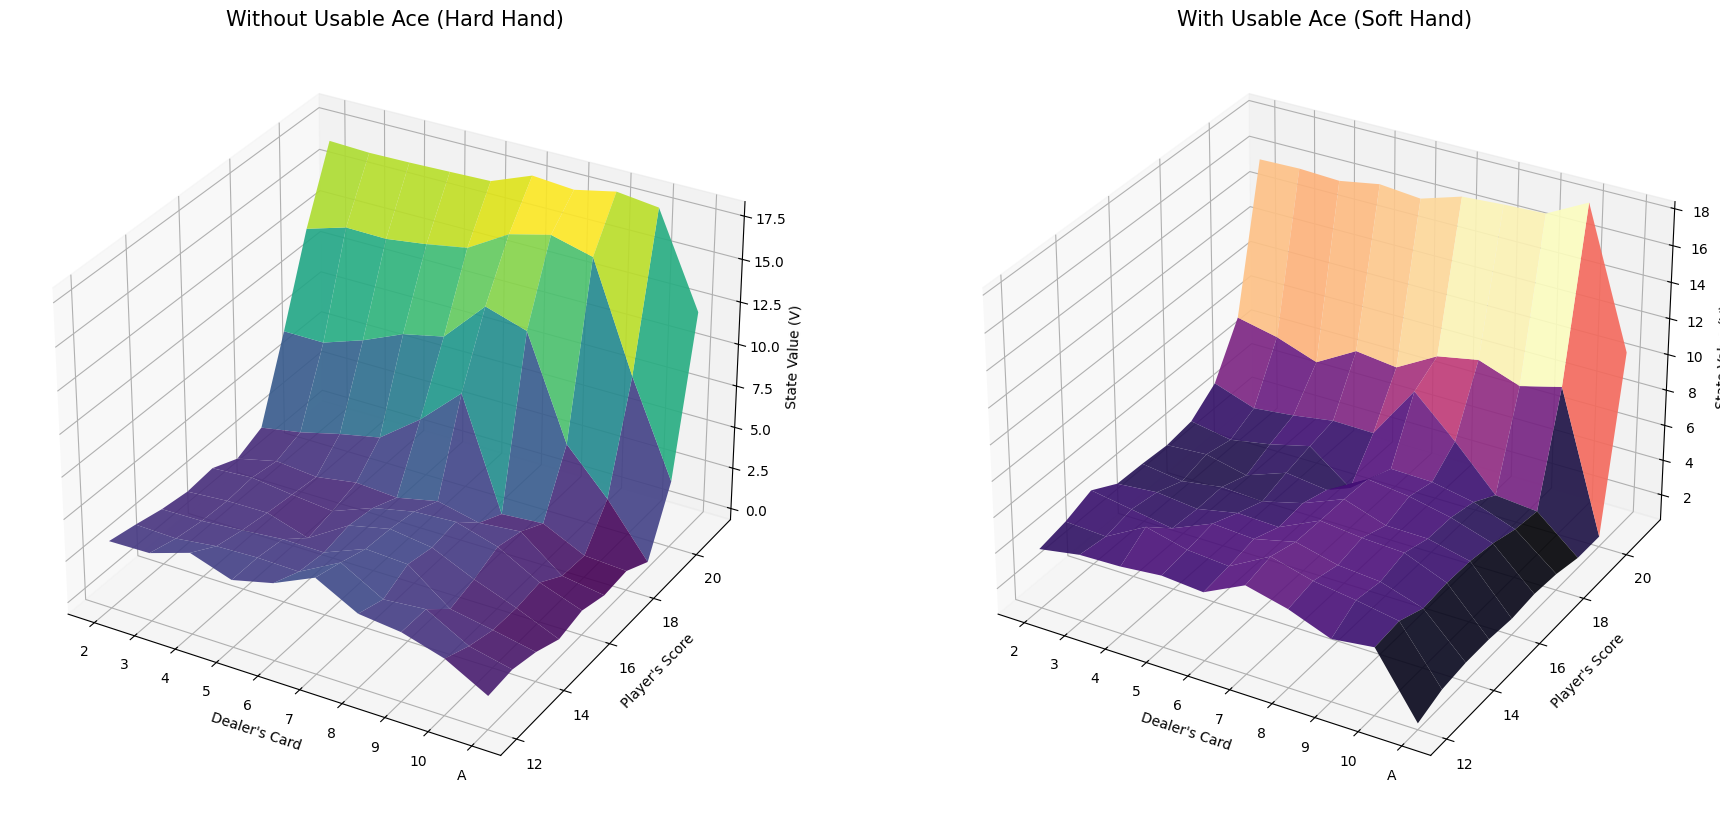

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_comparison(agent):
    player_range = np.arange(12, 22)
    dealer_range = np.arange(2, 12)
    X, Y = np.meshgrid(dealer_range, player_range)

    fig = plt.figure(figsize=(22, 10))

    # --- First Subplot: Without Usable Ace ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    Z_no_ace = np.array([[np.max(agent.q_table.get((p, d, False), [0, 0])) 
                    for d in dealer_range] for p in player_range])
    
    surf1 = ax1.plot_surface(X, Y, Z_no_ace, cmap='viridis', edgecolor='none', alpha=0.9)
    ax1.set_title('Without Usable Ace (Hard Hand)', fontsize=15)
    ax1.set_zlabel('State Value (V)')

    # --- Second Subplot: With Usable Ace ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    Z_ace = np.array([[np.max(agent.q_table.get((p, d, True), [0, 0])) 
                    for d in dealer_range] for p in player_range])
    
    surf2 = ax2.plot_surface(X, Y, Z_ace, cmap='magma', edgecolor='none', alpha=0.9)
    ax2.set_title('With Usable Ace (Soft Hand)', fontsize=15)
    ax2.set_zlabel('State Value (V)')

    for ax in [ax1, ax2]:
        ax.set_xlabel('Dealer\'s Card')
        ax.set_ylabel('Player\'s Score')
        ax.set_xticks(dealer_range)
        ax.set_xticklabels(['2','3','4','5','6','7','8','9','10','A'])

    plt.savefig("comparison_3d_blackjack.png")
    plt.show()

# Display
plot_3d_comparison(agent)

These surface plots represent $V(s) = \max Q(s, a)$, showing the expected long-term return for every possible hand.

**Peaks**: The sharp incline toward a player score of 21 represents the highest confidence in a win.

**Valleys**: The deep troughs at player scores of 14–16 against a dealer 10 or Ace highlight the "Danger Zone," where the probability of losing is maximized.

**Model Stability**: The smoothness of the 3D surface is a result of the implemented Learning Rate Decay. By reducing the $\alpha$ (Alpha) over time, we prevent late-stage random losses from oscillating the values, resulting in a stable and professional model representation.